# Multiclass Peak Detection in fDOM

This file combines all of the fDOM detection scripts into a singular classifier, that detects all peak types. On top of this, it also leverages the augmented data created previously.

## Structure

The core structure of the project is to have all individual classifiers running, and then when one detects a peak, it alerts the overall classifier "manager", which then takes note of the peak that a classifier has detected as an anomaly peak.


In [1]:
# Imports
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sn
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
)
import pandas as pd
import numpy as np
import datetime
import sys
import copy
import matplotlib.pyplot as plt
import pickle

sys.path.insert(1, "../")
import Tools.data_processing as dp
import Tools.data_movement as dm
from get_cands import get_all_cands_fDOM, get_all_truths_fDOM

# import classifiers
from fdom_classifiers.fDOM_PLP import fDOM_PLP_Classifier
from fdom_classifiers.fDOM_FPT import fDOM_FPT_Classifier
from fdom_classifiers.fDOM_FSK import fDOM_FSK_Classifier
from fdom_classifiers.fDOM_PP import fDOM_PP_Classifier
from fdom_classifiers.fDOM_SKP import fDOM_SKP_Classifier

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# TODO: REMOVE THIS WHEN FINISHED MODIFYING
%load_ext autoreload
%autoreload 2

## Training parameters and helper functions


In [3]:
ITERATIONS = 7000
NUM_SPLITS = 5
AUGMENT_DATA_BEGIN_TIMESTAMP = 2459096.9583333335
USE_AUGMENTED_DATA = True

# for confusion matrix
DATA_LABELS = ["PLP", "SKP", "PP", "NAP"]

# Useful functions
def get_prediction(plp_pred, skp_pred, pp_pred, fsk_pred=None, fpt_pred=None):
    """
    take the top level prediction based on peak precendence
    """
    
    if plp_pred == "PLP":
        return plp_pred

    elif pp_pred == "PP":
        return pp_pred

    elif skp_pred == "SKP":
        return skp_pred

    elif fsk_pred == "FSK":
        return fsk_pred
        
    elif fpt_pred == "FPT":
        return fpt_pred

    else:
        return "NAP"

In [4]:
# Filenames
fdom_raw_data = "../Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv"
stage_raw_data = "../Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv"
turb_raw_data = "../Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv"

fdom_labeled = "../Data/labeled_data/ground_truths/fDOM/fDOM_all_julian_0k-300k.csv"

fdom_raw_augmented = "../Data/augmented_data/fdom/unlabeled/unlabeled_fdom.csv"
fdom_labeled_augmented = "../Data/augmented_data/fdom/labeled/labeled_fdom_peaks.csv"

turb_augmented_raw_data = "../Data/augmented_data/fdom/unlabeled/unlabeled_turb.csv"

stage_augmented_data_fn = "../Data/augmented_data/fdom/unlabeled/unlabeled_stage.csv"

In [5]:
# Load Data
fDOM_data = dm.read_in_preprocessed_timeseries(fdom_raw_data)
stage_data = dm.read_in_preprocessed_timeseries(stage_raw_data)
turb_data = dm.read_in_preprocessed_timeseries(turb_raw_data)
stage_data = dp.align_stage_to_fDOM(fDOM_data, stage_data)

augmented_fdom_data = np.array(dm.read_in_timeseries(fdom_raw_augmented, True))
augmented_turb_data = np.array(dm.read_in_timeseries(turb_augmented_raw_data, True))
augmented_stage_data = np.array(dm.read_in_timeseries(stage_augmented_data_fn, True))


## Get Candidates and truths

In [6]:
# get candidates from raw data
cands = get_all_cands_fDOM(
    fdom_raw_data,
    fdom_labeled,
)

# get truths from raw data
truths = get_all_truths_fDOM(fdom_labeled)

# assert they are the same size
assert truths.shape == cands.shape

print(f"Total number of original data candidates: {cands.shape[0]}")


Total number of original data candidates: 1636


### Augmented Data
Make sure that `USE_AUGMENTED_DATA` == `True`, for this data to take effect

In [7]:
if USE_AUGMENTED_DATA:
    # get candidates from augmented data
    cands_augmented = get_all_cands_fDOM(
        fdom_raw_augmented,
        fdom_labeled_augmented,
        True,
    )

    truths_augmented = get_all_truths_fDOM(fdom_labeled_augmented, True)

    # align the missing augmented data (FPT, NFPT, FSK, NFSK, some others)
    truths_augmented = truths_augmented[
        truths_augmented["idx_of_peak"].isin(cands_augmented["idx_of_peak"])
    ]

    assert truths_augmented.shape == cands_augmented.shape

    print(f"Total number of augmented candidates: {cands_augmented.shape[0]}")

    # concatenate two candidates and truths into single list
    cands = pd.concat([cands, cands_augmented])
    truths = pd.concat([truths, truths_augmented])

    # concat augmented raw data to normal raw data, for classifier preprocessing
    turb_data_total = np.concatenate((turb_data, augmented_turb_data))
    fdom_total = np.concatenate((fDOM_data, augmented_fdom_data))
    stage_total = np.concatenate((stage_data, augmented_stage_data))

# if we aren't using augmented data, make sure classifiers have correct data being passed into them for preprocessing
else:
    turb_data_total = turb_data
    fdom_total = fDOM_data
    stage_total = stage_data

Total number of augmented candidates: 676


In [8]:
# Convert cands and truths into lists
cands = cands.values.tolist()

truths = truths.values.tolist()

print(str(len(cands)) + " candidates in provided data.")

2312 candidates in provided data.


## Create Classifiers


In [9]:
plp_classifer = fDOM_PLP_Classifier(
    fdom_total,
    turb_data_total,
    fdom_raw_data,
    fdom_labeled,
    fdom_raw_augmented,
    fdom_labeled_augmented
)


In [10]:
skp_classifier = fDOM_SKP_Classifier(
    fdom_total,
    fdom_raw_data,
    fdom_labeled,
    fdom_raw_augmented,
    fdom_labeled_augmented
)

In [11]:
pp_classifier = fDOM_PP_Classifier(
    fdom_total,
    stage_total, # CHANGED TO BE ENTURE STAGE, this could help
    AUGMENT_DATA_BEGIN_TIMESTAMP
)

In [12]:
fpt_classifier = fDOM_FPT_Classifier()

In [13]:
# fsK_classifier = fDOM_FSK_Classifier()

## Training Loop

In [17]:
accumulated_test_metrics = {}

accumulated_test_results = {}

accumulated_best_params = {}

accumulated_cfmxs = {}

discovered_labels = []

# split data
tss = TimeSeriesSplit(NUM_SPLITS)

overall_start = datetime.datetime.now()

split = 1
divide_by_zero_errs = 0

for train_val_indices, test_indices in tss.split(cands):
    X_train, y_train = [cands[i] for i in train_val_indices], [
        truths[i] for i in train_val_indices
    ]

    X_test, y_test = [cands[i] for i in test_indices], [truths[i] for i in test_indices]

    max_fold_metric = 0
    max_result = None

    print("\nSplit: ", split)

    split_start = datetime.datetime.now()

    # TODO: check on these two lines, unsure what they really do
    num_pos_test = len(list(filter(lambda x: x[2] != "NAP", y_test)))
    num_pos_train = len(list(filter(lambda x: x[2] != "NAP", y_train)))

    print(f"Num Pos in Test: {num_pos_test}")
    print(f"Num Pos in Train: {num_pos_train}")

    if num_pos_test >= 1 and num_pos_train >= 1:

        # main training loop
        for iteration in range(ITERATIONS):
            params = {}

            # start the iteration for each classifier (resets predictions, generates params)
            params["plp"] = plp_classifer.start_iteration()
            params["skp"] = skp_classifier.start_iteration()
            params["pp"] = pp_classifier.start_iteration()

            # reset results
            train_preds = []

            plp_preds = plp_classifer.classify_samples(X_train)
            skp_preds = skp_classifier.classify_samples(X_train)
            pp_preds = pp_classifier.classify_samples(X_train)
            for i, pred in enumerate(plp_preds):
                train_pred = get_prediction(pred[1], skp_preds[i][1], pp_preds[i][1])
                train_preds.append(train_pred)

            # iterate over list of peaks
            # for i, peak in enumerate(X_train):
            #     plp_result = plp_classifer.classify_sample(i, peak)
            #     skp_result = skp_classifier.classify_sample(i, peak)
            #     pp_result = pp_classifier.classify_sample(i, peak)

            #     # append to results data structure, the index of peak, and all of the results
            #     pred = get_prediction(plp_result, skp_result, pp_result)
            #     train_preds.append([peak[0], pred])

            # print out info for user
            if iteration and iteration % int(ITERATIONS / 10) == 0:
                print(" {}/{} ".format(iteration, ITERATIONS), end="")

            # test predictions
            # FIXME: the balanced acc is extremely low for some reason

            bal_acc = balanced_accuracy_score(
                [row[2] for row in y_train],
                [row for row in train_preds],
            )

            acc = accuracy_score(
                [row[2] for row in y_train],
                [row for row in train_preds],
            )

            f1_train = f1_score(
                [row[2] for row in y_train],
                [row for row in train_preds],
                average=None
            )

            # check acc
            if f1_train[0] > max_fold_metric:
                print(f1_train[0])
                max_fold_metric = f1_train[0]
                max_result = copy.deepcopy(train_preds)

                # save params of classifiers
                plp_classifer.got_best_result()
                skp_classifier.got_best_result()
                pp_classifier.got_best_results()

            # call end of iteration, as we are at the end of an iteration
            # allows individual classifiers to calc results
            plp_classifer.end_of_iteration(y_train)
            skp_classifier.end_of_iteration(y_train)
            pp_classifier.end_of_iteration(y_train)

        # perform peak testing
        test_preds = []
        plp_preds = plp_classifer.classify_samples(X_test, True)
        skp_preds = skp_classifier.classify_samples(X_test, True)
        pp_preds = pp_classifier.classify_samples(X_test, True)
        for i, pred in enumerate(plp_preds):
            test_pred = get_prediction(pred[1], skp_preds[i][1], pp_preds[i][1])
            test_preds.append(test_pred)

        # for i, peak in enumerate(X_test):
        #     # classify all samples
        #     plp_result = plp_classifer.classify_sample(i, peak, True)
        #     skp_result = skp_classifier.classify_sample(i, peak, True)
        #     pp_result = pp_classifier.classify_sample(i, peak, True)

        #     # if any samples are anomaly peak, we need to use them
        #     pred = get_prediction(plp_result, skp_result, pp_result)

        #     # append to results data structure, the index of peak, and the prediction
        #     test_preds.append([peak[0], pred])

        # get confusion matrix
        cfmx = confusion_matrix(
            [row[2] for row in y_test],
            [row for row in test_preds],
            labels=DATA_LABELS,
        )

        # get acc score
        acc_score = accuracy_score(
            [row[2] for row in y_test],
            [row for row in test_preds],
        )

        bal_acc = balanced_accuracy_score(
            [row[2] for row in y_test],
            [row for row in test_preds],
        )

        f1 = f1_score(
            [row[2] for row in y_test],
            [row for row in test_preds],
            average="weighted",
        )

        precision = precision_score(
            [row[2] for row in y_test],
            [row for row in test_preds],
            average="weighted",
        )

        print(f"\nSplit: {split} Test Scores: F1: {f1}  BA: {bal_acc}  ACC: {acc_score}")

        accumulated_cfmxs[split] = copy.deepcopy(cfmx)

        accumulated_test_metrics[split] = {
            "f1": f1,
            "acc": acc_score,
            "ba": bal_acc,
            "precision": precision,
        }

        accumulated_test_results[split] = copy.deepcopy(test_preds)

        # save the best params
        accumulated_best_params[split] = {
            "PLP": copy.deepcopy(plp_classifer.best_params),
            "SKP": copy.deepcopy(skp_classifier.best_params),
            "PP": copy.deepcopy(pp_classifier.best_params),
        }

        # increment split
        split += 1

# print a newline char for better display
print("\n")

overall_end_time = datetime.datetime.now()



Split:  1
Num Pos in Test: 21
Num Pos in Train: 33
0.9361111111111111
0.9592391304347825
0.959349593495935
0.9606512890094979
 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 
Split: 1 Test Scores: F1: 0.9084353741496599  BA: 0.2115884115884116  ACC: 0.9168831168831169

Split:  2
Num Pos in Test: 23
Num Pos in Train: 54
 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 
Split: 2 Test Scores: F1: 0.9170752535136096  BA: 0.24585635359116023  ACC: 0.9246753246753247

Split:  3
Num Pos in Test: 37
Num Pos in Train: 77
 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 
Split: 3 Test Scores: F1: 0.8448097104564422  BA: 0.19310344827586207  ACC: 0.8727272727272727

Split:  4
Num Pos in Test: 155
Num Pos in Train: 114
 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 
Split: 4 Test Scores: F1: 0.4776595

## Display Metrics


Mean Test F1:  0.6942432933971908
Mean Test BA:  0.23591572180815165
Mean Test Acc:  0.7574025974025973
Mean Test Precision:  0.6667504565511011

Params from split 1:

For peak type PLP:
max_basewidth, value: 7
min_prominence, value: 7.19136497563519
interference_x_proximity, value: 7
interference_y_proximity, value: 3
proximity_threshold, value: 9

For peak type SKP:
max_basewidth, value: 6
min_prominence, value: 9.410116932884762
downward_bases_threshold, value: 3
proximity_threshold, value: 13

For peak type PP:
x, value: 85
y, value: 53
ratio_threshold, value: 11.362180331109082

Params from split 2:

For peak type PLP:
max_basewidth, value: 7
min_prominence, value: 7.19136497563519
interference_x_proximity, value: 7
interference_y_proximity, value: 3
proximity_threshold, value: 9

For peak type SKP:
max_basewidth, value: 6
min_prominence, value: 9.410116932884762
downward_bases_threshold, value: 3
proximity_threshold, value: 13

For peak type PP:
x, value: 85
y, value: 53
ratio_th

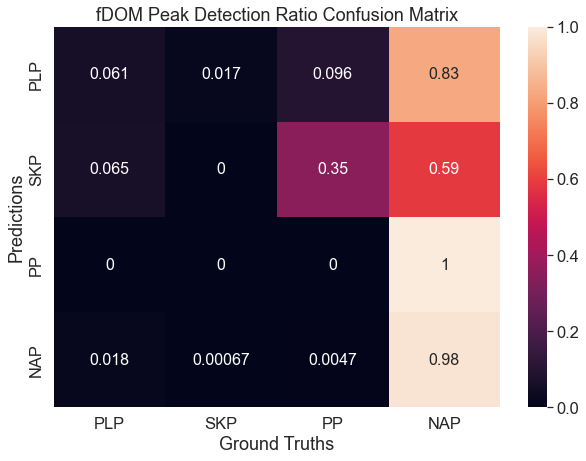

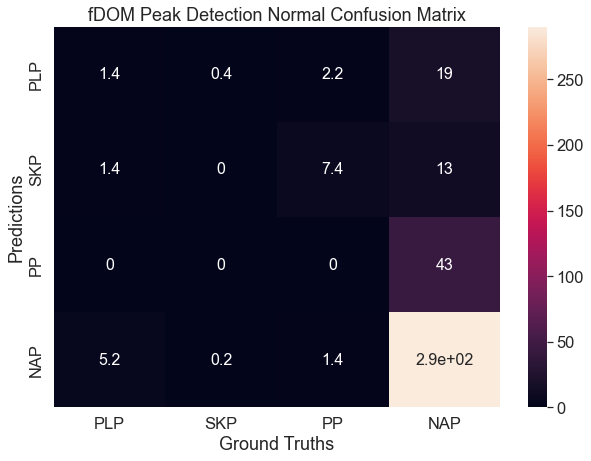

In [19]:
mean_f1 = 0
mean_ba = 0
mean_precision = 0
mean_acc = 0

for key in accumulated_test_metrics:
    metrics = accumulated_test_metrics[key]

    mean_f1 += metrics["f1"]
    mean_ba += metrics["ba"]
    mean_precision += metrics["precision"]
    mean_acc += metrics["acc"]

print("Mean Test F1: ", mean_f1 / len(accumulated_test_metrics))
print("Mean Test BA: ", mean_ba / len(accumulated_test_metrics))
print("Mean Test Acc: ", mean_acc / len(accumulated_test_metrics))
print("Mean Test Precision: ", mean_precision / len(accumulated_test_metrics))

for split in accumulated_best_params.keys():
    print(f"\nParams from split {split}:")
    for peak in accumulated_best_params[split].keys():
        print(f"\nFor peak type {peak}:")

        for param in accumulated_best_params[split][peak].keys():
            print(f"{param}, value: {accumulated_best_params[split][peak][param]}")

# print("Training time: ", overall_end_time - overall_start)

mean_cfmx = np.zeros((len(DATA_LABELS), len(DATA_LABELS)))
for key in accumulated_cfmxs.keys():
    mean_cfmx += accumulated_cfmxs[key]

mean_cfmx = mean_cfmx / len(accumulated_cfmxs)

plt.figure(figsize=(10, 7))
plt.title(label="fDOM Peak Detection Ratio Confusion Matrix")

sn.set(font_scale=1.5)

sn.heatmap(
    pd.DataFrame(
        mean_cfmx.astype("float") / mean_cfmx.sum(axis=1)[:, np.newaxis],
        index=DATA_LABELS,
        columns=DATA_LABELS,
    ),
    annot=True,
    annot_kws={"size": 16},
)

plt.xlabel("Ground Truths")
plt.ylabel("Predictions")
plt.show()

plt.figure(figsize=(10, 7))
plt.title(label="fDOM Peak Detection Normal Confusion Matrix")

sn.set(font_scale=1.5)

sn.heatmap(
    pd.DataFrame(
        mean_cfmx,
        index=DATA_LABELS,
        columns=DATA_LABELS,
    ),
    annot=True,
    annot_kws={"size": 16},
)

plt.xlabel("Ground Truths")
plt.ylabel("Predictions")
plt.show()


In [20]:
with open('./Experimental_Results/fdom_multiclass/best_params.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_best_params, pck_file)
    pck_file.close()
    
# Pickle test results
with open('./Experimental_Results/fdom_multiclass/test_results.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_test_results, pck_file)
    pck_file.close()

# Pickle test metrics
with open('./Experimental_Results/fdom_multiclass/test_metrics.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_test_metrics, pck_file)
    pck_file.close()

### Statistics from individual classifiers

In [21]:
# print accuracies
print("PLP CLASSIFIER INFO:")
print("ACC: " + str(plp_classifer.best_acc))
print("f1: " + str(plp_classifer.best_f1_score))
print("\n")

print("SKP CLASSIFIER INFO:")
print("ACC: " + str(skp_classifier.best_acc))
print("f1: " + str(skp_classifier.best_f1_score))
print("\n")

print("PP CLASSIFIER INFO:")
print("ACC: " + str(pp_classifier.best_acc))
print("f1: " + str(pp_classifier.best_f1_score))
print("\n")


PLP CLASSIFIER INFO:
ACC: 0.6800024050024049
f1: 0.46296296296296297


SKP CLASSIFIER INFO:
ACC: 0.6888828763828764
f1: 0.41379310344827586


PP CLASSIFIER INFO:
ACC: 0.6568783068783068
f1: 0.357429718875502


